In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

In [ ]:
MASTER_LIST_PATH = "/content/drive/MyDrive/voice_project/final_master_gold_list.csv"
GENDER_LIST_PATH = "/content/drive/MyDrive/voice_project/balanced_gender_list.csv"
AGE_LIST_PATH = "/content/drive/MyDrive/voice_project/balanced_age_list_50plus.csv"

In [ ]:

print("Loading Master List...")
df = pd.read_csv(MASTER_LIST_PATH)

# Clean Labels (Standardize)
df['gender'] = df['gender'].map({
    'male_masculine': 'male', 'female_feminine': 'female',
    'male': 'male', 'female': 'female'
})
age_map = {
    'teens': 'teens', 'twenties': 'twenties', 'thirties': 'thirties',
    'fourties': 'fourties', 'fifties': 'fifties',
    'sixties': '60plus', 'seventies': '60plus'
}
df['age'] = df['age'].map(age_map)
df = df.dropna(subset=['age', 'gender'])

print(f"Total Clean Files: {len(df)}")

Loading Master List...
Total Clean Files: 84691


In [ ]:
# Finding the smallest gender group

g_counts = df['gender'].value_counts()
print(g_counts)

n_gender = g_counts.min()

print(f"\n--- Creating Gender Dataset ---")
print(f"Smallest Gender Group: {n_gender}")

gender
male      73818
female    10873
Name: count, dtype: int64

--- Creating Gender Dataset ---
Smallest Gender Group: 10873


In [ ]:
df_gender_balanced = df.groupby('gender').apply(
    lambda x: x.sample(n_gender, random_state=42)
).reset_index(drop=True)

print(f"Balanced Gender Dataset: {len(df_gender_balanced)} clips")

Balanced Gender Dataset: 21746 clips


/tmp/ipython-input-681199321.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gender_balanced = df.groupby('gender').apply(


In [ ]:
df_gender_balanced.shape
df_gender_balanced.to_csv(GENDER_LIST_PATH, index=False)

In [ ]:
# Find smallest age group, sample that amount from all 6 groups.
a_counts = df['age'].value_counts()
print(a_counts)
n_age = a_counts.min()

print(f"\n--- Creating Age Dataset ---")
print(f"Smallest Age Group: {n_age}")

age
twenties    31961
thirties    19050
fourties    12415
fifties      9222
teens        7051
60plus       4992
Name: count, dtype: int64

--- Creating Age Dataset ---
Smallest Age Group: 4992


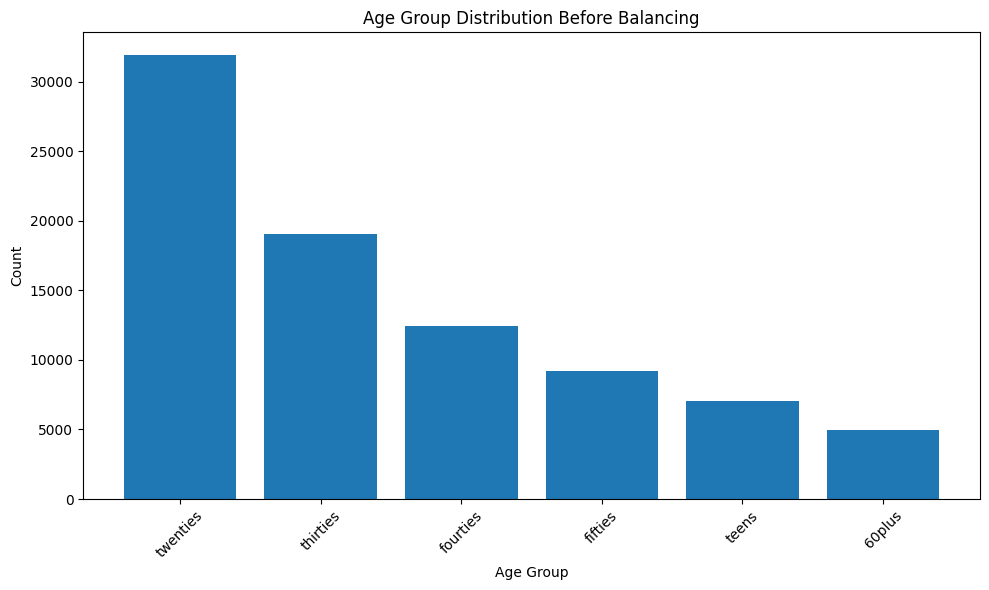

In [ ]:
import matplotlib.pyplot as plt

age_counts = df['age'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(age_counts.index.astype(str), age_counts.values)

plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Age Group Distribution Before Balancing")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df_age_balanced = df.groupby('age').apply(
    lambda x: x.sample(n_age, random_state=42)
).reset_index(drop=True)

print(f"Balanced Age Dataset: {len(df_age_balanced)} clips")


Balanced Age Dataset: 29952 clips


/tmp/ipython-input-2062291802.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_age_balanced = df.groupby('age').apply(


In [ ]:
df_age_balanced.to_csv(AGE_LIST_PATH, index=False)

In [ ]:
import pandas as pd
import os

# Config
MASTER_LIST_PATH = "/content/drive/MyDrive/voice_project/final_master_gold_list.csv"
AGE_LIST_PATH = "/content/drive/MyDrive/voice_project/balanced_age_list_50plus.csv"
FEATURES_DIR = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"
TO_DO_LIST_PATH = "/content/drive/MyDrive/voice_project/files_to_process_age.csv"

# 1. Load & Clean ---
if os.path.exists(MASTER_LIST_PATH):
    print("Loading Master List...")
    df = pd.read_csv(MASTER_LIST_PATH)

    # Standardize Gender
    df['gender'] = df['gender'].map({
        'male_masculine': 'male', 'female_feminine': 'female',
        'male': 'male', 'female': 'female'
    })

    # 2. THE 50PLUS STRATEGY ---
    age_map = {
        'teens': 'teens',
        'twenties': 'twenties',
        'thirties': 'thirties',
        'fourties': 'fourties',
        'fifties': '50plus',
        'sixties': '50plus',
        'seventies': '50plus',
        'eighties': '50plus',
        'nineties': '50plus',
        '60plus': '50plus'
    }
    df['age'] = df['age'].map(age_map)
    df = df.dropna(subset=['age', 'gender'])

    print(f"\n--- Raw Distribution (After Merging 50+) ---")
    print(df['age'].value_counts())


    TARGET_N = 12000

    balanced_fragments = []

    print(f"\n--- Sampling (Cap at {TARGET_N}) ---")
    for age_group, group_data in df.groupby('age'):
        # If group is bigger than 12k, take 12k.
        # If smaller (like teens), take ALL of it.
        n_samples = min(len(group_data), TARGET_N)

        sampled_group = group_data.sample(n_samples, random_state=42)
        balanced_fragments.append(sampled_group)
        print(f"   {age_group:<10}: Taken {len(sampled_group)} / {len(group_data)}")

    # Combine
    df_age_final = pd.concat(balanced_fragments).sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\n Final Age Dataset Size: {len(df_age_final)} clips")

    # 4. Check for New Files
    # Determine which .mp3s haven't been converted to .npy yet
    if os.path.exists(FEATURES_DIR):
        df_age_final['npy_path'] = df_age_final['path'].str.replace('.mp3', '.npy')
        existing_files = set(os.listdir(FEATURES_DIR))

        df_age_final['exists'] = df_age_final['npy_path'].isin(existing_files)
        new_files_needed = df_age_final[~df_age_final['exists']]

        print(f"\n Processing Workload:")
        print(f"   Total clips in dataset: {len(df_age_final)}")
        print(f"   Already processed:      {df_age_final['exists'].sum()}")
        print(f"   NEW files to process:   {len(new_files_needed)}")

        # Save the dataset list
        df_age_final.to_csv(AGE_LIST_PATH, index=False)
        print(f"\n Saved Balanced Age List to: {AGE_LIST_PATH}")

        # Save the "To Do" list for the feature extractor
        if len(new_files_needed) > 0:
            new_files_needed.to_csv(TO_DO_LIST_PATH, index=False)
            print(f". Saved list of new files to process to: {TO_DO_LIST_PATH}")
        else:
            print(" No new files to process! You can skip feature extraction.")

    else:
        print(". Features directory not found. You will need to process ALL files.")
        df_age_final.to_csv(AGE_LIST_PATH, index=False)
else:
    print(" Master list not found! Check path.")

Loading Master List...

--- Raw Distribution (After Merging 50+) ---
age
twenties    31961
thirties    19050
50plus      14217
fourties    12415
teens        7051
Name: count, dtype: int64

--- Sampling (Cap at 12000) ---
   50plus    : Taken 12000 / 14217
   fourties  : Taken 12000 / 12415
   teens     : Taken 7051 / 7051
   thirties  : Taken 12000 / 19050
   twenties  : Taken 12000 / 31961

 Final Age Dataset Size: 55051 clips

 Processing Workload:
   Total clips in dataset: 55051
   Already processed:      8260
   NEW files to process:   46791

 Saved Balanced Age List to: /content/drive/MyDrive/voice_project/balanced_age_list_50plus.csv
. Saved list of new files to process to: /content/drive/MyDrive/voice_project/files_to_process_age.csv


*Section 2*

**Audio clip extraction and processing part**

In [ ]:
!apt-get install -y ffmpeg
!pip install librosa tqdm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

In [ ]:
# 1. Input: The "To Do" list we just created
TODO_LIST_PATH = "/content/drive/MyDrive/voice_project/files_to_process_age.csv"

# 2. Output: The SAME features folder as before
FEATURES_DIR = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"

# 3. Source Audio: Where the MP3s live
PROJECT_PATH = "/content/drive/MyDrive/Voice project/unzipped_dataset/cv-corpus-23.0-2025-09-05/en/"
CLIPS_PATH = os.path.join(PROJECT_PATH, "clips")

In [ ]:
# 1. Install dependencies
!apt-get install -y ffmpeg
!pip install librosa tqdm joblib

import librosa
import numpy as np
import pandas as pd
import os
import shutil
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed

# --- Config ---
TODO_LIST_PATH = "/content/drive/MyDrive/voice_project/files_to_process_age.csv"
FEATURES_DIR = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"
SOURCE_CLIPS_DIR = "/content/drive/MyDrive/Voice project/unzipped_dataset/cv-corpus-23.0-2025-09-05/en/clips"
LOCAL_CLIPS_DIR = "/content/clips" # Fast local storage

# Audio Settings (Must match Gender data exactly)
SAMPLE_RATE = 22050
DURATION = 5
N_MELS = 128
FIXED_LENGTH = SAMPLE_RATE * DURATION
N_FFT = 2048
HOP_LENGTH = 512

# --- 1. Fast Copy Function (Multi-Threaded) ---
def copy_file_worker(filename):
    src = os.path.join(SOURCE_CLIPS_DIR, filename)
    dst = os.path.join(LOCAL_CLIPS_DIR, filename)
    if not os.path.exists(dst):
        try:
            if os.path.exists(src):
                shutil.copy(src, dst)
                return 1 # Success
        except:
            return 0 # Fail
    return 0 # Already exists or fail

# --- 2. Processing Function (Parallel) ---
def process_file_worker(filename):
    local_path = os.path.join(LOCAL_CLIPS_DIR, filename)
    npy_path = os.path.join(FEATURES_DIR, filename.replace('.mp3', '.npy'))

    # Skip if already done
    if os.path.exists(npy_path): return 0

    try:
        # Load (Fast from local SSD)
        audio, sr = librosa.load(local_path, sr=SAMPLE_RATE)

        # Pad/Truncate
        if len(audio) < FIXED_LENGTH:
            audio = np.pad(audio, (0, FIXED_LENGTH - len(audio)), 'constant')
        else:
            audio = audio[:FIXED_LENGTH]

        # Spectrogram
        spec = librosa.feature.melspectrogram(
            y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        log_spec = librosa.power_to_db(spec, ref=np.max).astype(np.float32)

        # Save to Drive
        np.save(npy_path, log_spec)
        return 1 # Success
    except:
        return 0 # Fail

# --- MAIN EXECUTION ---
if os.path.exists(TODO_LIST_PATH):
    df = pd.read_csv(TODO_LIST_PATH)
    files_list = df['path'].tolist()

    print(f"Turbo Processing for {len(files_list)} files")

    # PHASE 1: COPY
    print(f"\n Copying files to local disk (8 Threads)...")
    os.makedirs(LOCAL_CLIPS_DIR, exist_ok=True)

    # Use 8 threads to pull from Drive faster
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(executor.map(copy_file_worker, files_list), total=len(files_list), desc="Copying"))

    print("   Copying complete. Starting processing...")

    # PHASE 2: PROCESS
    print(f"\n Generating Spectrograms (2 CPU Cores)...")
    os.makedirs(FEATURES_DIR, exist_ok=True)

    # Use joblib to use all CPU cores (n_jobs=-1)
    # batch_size='auto' helps reduce overhead
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(process_file_worker)(f) for f in files_list
    )

    print(f"\n DONE! {sum(results)} new files created.")

else:
    print("To-Do list not found!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
🚀 Turbo Processing for 46791 files

1️⃣ Copying files to local disk (8 Threads)...


Copying:   0%|          | 0/46791 [00:00<?, ?it/s]

   Copying complete. Starting processing...

2️⃣ Generating Spectrograms (2 CPU Cores)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3408 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4488 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5712 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 7080 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 8592 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 10248 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 11922 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 13756 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 15844 tasks   


✅ DONE! 45759 new files created.


[Parallel(n_jobs=-1)]: Done 46791 out of 46791 | elapsed: 27.1min finished


In [ ]:
import pandas as pd
import os

# --- Config ---
GENDER_LIST_PATH = "/content/drive/MyDrive/voice_project/balanced_gender_list.csv"
FEATURES_DIR = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"
GENDER_TODO_PATH = "/content/drive/MyDrive/voice_project/files_to_process_gender.csv"

# --- Check ---
if os.path.exists(GENDER_LIST_PATH) and os.path.exists(FEATURES_DIR):
    df = pd.read_csv(GENDER_LIST_PATH)
    existing_files = set(os.listdir(FEATURES_DIR))

    # Calculate Missing
    df['npy_path'] = df['path'].str.replace('.mp3', '.npy')
    df['exists'] = df['npy_path'].isin(existing_files)

    missing_files = df[~df['exists']]

    print(f" Gender Dataset Status:")
    print(f"   Total Clips:      {len(df)}")
    print(f"   Already Processed: {df['exists'].sum()}")
    print(f"   Missing:           {len(missing_files)}")

    if len(missing_files) > 0:
        missing_files.to_csv(GENDER_TODO_PATH, index=False)
        print(f"\n Found {len(missing_files)} missing files.")
        print(f" Saved list to: {GENDER_TODO_PATH}")
        print(" You should run the 'Turbo Processor' script one more time using this list!")
    else:
        print("\n All Gender files are ready! No extra processing needed.")

else:
    print(" Could not find lists or feature folder.")

📊 Gender Dataset Status:
   Total Clips:      21746
   Already Processed: 16098
   Missing:           5648

⚠️ Found 5648 missing files.
📝 Saved list to: /content/drive/MyDrive/voice_project/files_to_process_gender.csv
👉 You should run the 'Turbo Processor' script one more time using this list!


In [ ]:
# 1. Install dependencies
!apt-get install -y ffmpeg
!pip install librosa tqdm joblib

import librosa
import numpy as np
import pandas as pd
import os
import shutil
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed

# --- Config ---
# 1. The specific list of 5,648 missing gender files
TODO_LIST_PATH = "/content/drive/MyDrive/voice_project/files_to_process_gender.csv"

# 2. Paths
FEATURES_DIR = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"
SOURCE_CLIPS_DIR = "/content/drive/MyDrive/Voice project/unzipped_dataset/cv-corpus-23.0-2025-09-05/en/clips"
LOCAL_CLIPS_DIR = "/content/clips" # Fast local storage

# Audio Settings (Must match Age data exactly)
SAMPLE_RATE = 22050
DURATION = 5
N_MELS = 128
FIXED_LENGTH = SAMPLE_RATE * DURATION
N_FFT = 2048
HOP_LENGTH = 512

# --- 1. Fast Copy Function (Multi-Threaded) ---
def copy_file_worker(filename):
    src = os.path.join(SOURCE_CLIPS_DIR, filename)
    dst = os.path.join(LOCAL_CLIPS_DIR, filename)

    # Only copy if not already there
    if not os.path.exists(dst):
        try:
            if os.path.exists(src):
                shutil.copy(src, dst)
                return 1 # Copied
        except:
            return 0 # Fail
    return 0 # Already exists or fail

# --- 2. Processing Function (Parallel) ---
def process_file_worker(filename):
    local_path = os.path.join(LOCAL_CLIPS_DIR, filename)
    npy_path = os.path.join(FEATURES_DIR, filename.replace('.mp3', '.npy'))

    # Skip if already done
    if os.path.exists(npy_path): return 0

    try:
        # Load
        audio, sr = librosa.load(local_path, sr=SAMPLE_RATE)

        # Pad/Truncate
        if len(audio) < FIXED_LENGTH:
            audio = np.pad(audio, (0, FIXED_LENGTH - len(audio)), 'constant')
        else:
            audio = audio[:FIXED_LENGTH]

        # Spectrogram
        spec = librosa.feature.melspectrogram(
            y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        log_spec = librosa.power_to_db(spec, ref=np.max).astype(np.float32)

        # Save
        np.save(npy_path, log_spec)
        return 1 # Success
    except:
        return 0 # Fail

# MAIN EXECUTION
if os.path.exists(TODO_LIST_PATH):
    df = pd.read_csv(TODO_LIST_PATH)
    files_list = df['path'].tolist()

    print(f" Turbo Processing for {len(files_list)} missing Gender files")

    # COPY
    print(f"\n Copying files to local disk (8 Threads)...")
    os.makedirs(LOCAL_CLIPS_DIR, exist_ok=True)

    with ThreadPoolExecutor(max_workers=8) as executor:
        list(tqdm(executor.map(copy_file_worker, files_list), total=len(files_list), desc="Copying"))

    print("   Copying complete. Starting processing...")

    # PROCESS
    print(f"\n Generating Spectrograms (2 CPU Cores)...")
    os.makedirs(FEATURES_DIR, exist_ok=True)

    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(process_file_worker)(f) for f in files_list
    )

    print(f"\nDONE! {sum(results)} new Gender files created.")

else:
    print("To-Do list not found!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
🚀 Turbo Processing for 5648 missing Gender files

1️⃣ Copying files to local disk (8 Threads)...


Copying:   0%|          | 0/5648 [00:00<?, ?it/s]

   Copying complete. Starting processing...

2️⃣ Generating Spectrograms (2 CPU Cores)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2104 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2716 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4720 tasks      | elapsed:  5.2min



✅ DONE! 5632 new Gender files created.


[Parallel(n_jobs=-1)]: Done 5648 out of 5648 | elapsed:  5.7min finished
